In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

from scipy.optimize import minimize


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../../aparent/data/polyadb_features_pas_3_perturb.csv', sep='\t')

save_dict = np.load("../../../aparent/data/polyadb_features_pas_3_perturb_no_x.npz", allow_pickle=True)
m, ids, l, c, y = save_dict['m'], save_dict['ids'], save_dict['l'], save_dict['c'], save_dict['y']

s = np.load('../predictions/apa_perturb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy')

#Mark intronic sites
intron_mask = np.zeros(m.shape)
for k in range(m.shape[1]) :
    intron_mask[:, k] = np.array((df['pas_exists_' + str(k)] & df['site_type_' + str(k)].isin(['Intron', 'Internal_exon'])).astype(int).values, dtype=np.int32)

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("ids.shape = " + str(ids.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("intron_mask.shape = " + str(intron_mask.shape))


s.shape = (7740, 10)
m.shape = (7740, 10)
ids.shape = (7740, 10)
l.shape = (7740, 10)
c.shape = (7740, 10, 28)
y.shape = (7740, 10, 28)
intron_mask.shape = (7740, 10)


In [4]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes (and apply filters)

'''
CDC73
CTR9
LEO1
PAF1
'''

cell_type_1 = 'NT'
cell_type_2 = 'PAF1'#'PAF1'

min_c_1 = 10.
min_c_2 = 10.

min_total_l = 300
max_total_l = 1e6

min_l = np.min(l + (l == 0.) * 1e6, axis=-1)
max_l = np.max(l, axis=-1)

c_1 = c[:, :, cell_type_dict[cell_type_1]]
y_1 = y[:, :, cell_type_dict[cell_type_1]]

c_2 = c[:, :, cell_type_dict[cell_type_2]]
y_2 = y[:, :, cell_type_dict[cell_type_2]]

keep_index = np.nonzero((intron_mask[:, 0] <= 1.) & ((((min_l >= min_total_l) & (max_l <= max_total_l)) & ((np.sum(c_1, axis=-1) >= min_c_1) & (np.sum(c_2, axis=-1) >= min_c_2))) & (((y_1[:, 0] > 0.) & (y_1[:, 0] < 1.)) & ((y_2[:, 0] > 0.) & (y_2[:, 0] < 1.)))))[0]

s = s[keep_index, :]
m = m[keep_index, :]
l = l[keep_index, :]
c_1 = c_1[keep_index, :]
y_1 = y_1[keep_index, :]
c_2 = c_2[keep_index, :]
y_2 = y_2[keep_index, :]
intron_mask = intron_mask[keep_index, :]

print("s.shape = " + str(s.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c_1.shape = " + str(c_1.shape))
print("y_1.shape = " + str(y_1.shape))
print("c_2.shape = " + str(c_2.shape))
print("y_2.shape = " + str(y_2.shape))
print("intron_mask.shape = " + str(intron_mask.shape))


s.shape = (6644, 10)
m.shape = (6644, 10)
l.shape = (6644, 10)
c_1.shape = (6644, 10)
y_1.shape = (6644, 10)
c_2.shape = (6644, 10)
y_2.shape = (6644, 10)
intron_mask.shape = (6644, 10)


In [5]:

l_prox_cumulative = np.log(np.cumsum(l[:, ::-1], axis=1) * m[:, ::-1] + 1.)[:, ::-1]
l_cumulative = np.log(np.cumsum(l, axis=1) * m + 1.)
l = np.log(l * m + 1.)


In [6]:

prox_index = np.array([np.nonzero(m[i, :])[0][0] for i in range(m.shape[0])])
dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

prox_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    prox_mask[i, prox_index[i]] = 1.

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


In [7]:

y_1_prox = []
y_2_prox = []
for i in range(s.shape[0]) :
    y_1_prox.append(y_1[i, prox_index[i]])
    y_2_prox.append(y_2[i, prox_index[i]])

y_1_prox = np.array(y_1_prox)
y_2_prox = np.array(y_2_prox)

logodds_1_prox = np.log(y_1_prox / (1. - y_1_prox))
logodds_2_prox = np.log(y_2_prox / (1. - y_2_prox))

lor_prox = logodds_2_prox - logodds_1_prox


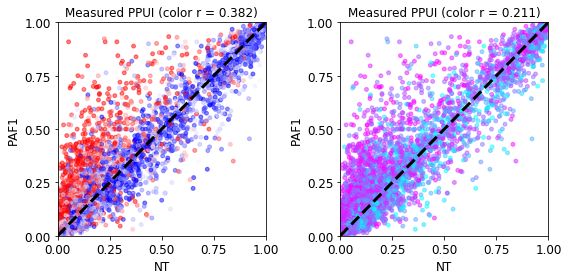

In [8]:
from scipy.stats import spearmanr, pearsonr

f, ax = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax[0])

y_pred = l[:, 1]

r_val, _ = spearmanr(y_pred, lor_prox)

low_qtl = np.quantile(y_pred, q=0.1)
high_qtl = np.quantile(y_pred, q=0.9)

plt.scatter(y_1_prox, y_2_prox, cmap='bwr', c=y_pred, vmin=low_qtl, vmax=high_qtl, s=15, alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI (color r = " + str(round(r_val, 3)) + ")", fontsize=12)


plt.sca(ax[1])

y_pred = s[:, 0]

r_val, _ = spearmanr(y_pred, lor_prox)

low_qtl = np.quantile(y_pred, q=0.1)
high_qtl = np.quantile(y_pred, q=0.9)

plt.scatter(y_1_prox, y_2_prox, cmap='cool', c=y_pred, vmin=low_qtl, vmax=high_qtl, s=15, alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI (color r = " + str(round(r_val, 3)) + ")", fontsize=12)

plt.tight_layout()

plt.show()


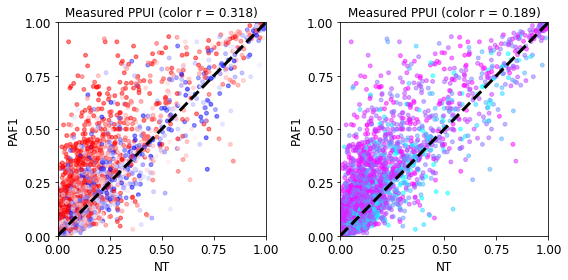

In [9]:
#Intronic sites only

from scipy.stats import spearmanr, pearsonr

keep_index = np.nonzero(intron_mask[:, 0] == 1)[0]

f, ax = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax[0])

y_pred = l[:, 1]

r_val, _ = spearmanr(y_pred[keep_index], lor_prox[keep_index])

low_qtl = np.quantile(y_pred, q=0.1)
high_qtl = np.quantile(y_pred, q=0.9)

plt.scatter(y_1_prox[keep_index], y_2_prox[keep_index], cmap='bwr', c=y_pred[keep_index], vmin=low_qtl, vmax=high_qtl, s=15, alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI (color r = " + str(round(r_val, 3)) + ")", fontsize=12)


plt.sca(ax[1])

y_pred = s[:, 0]

r_val, _ = spearmanr(y_pred[keep_index], lor_prox[keep_index])

low_qtl = np.quantile(y_pred, q=0.1)
high_qtl = np.quantile(y_pred, q=0.9)

plt.scatter(y_1_prox[keep_index], y_2_prox[keep_index], cmap='cool', c=y_pred[keep_index], vmin=low_qtl, vmax=high_qtl, s=15, alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI (color r = " + str(round(r_val, 3)) + ")", fontsize=12)

plt.tight_layout()

plt.show()


Optimization terminated successfully.
         Current function value: 0.554886
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
[ 0.05535569  0.17501348 -1.10059868]
Optimization terminated successfully.
         Current function value: 0.562686
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
[ 0.          0.18985945 -1.29917978]
- Spearman r = 0.399
- Spearman r (baseline) = 0.382
- n = 6644


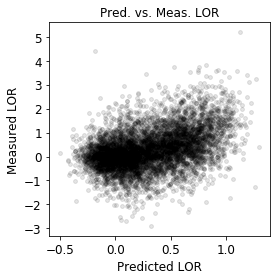

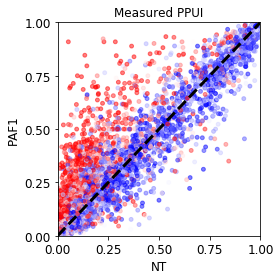

(y_thresh = 0.693)
AUC (baseline) = 0.741
AUC = 0.75


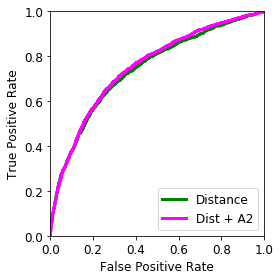

AP (baseline) = 0.535
AP = 0.537
APR (baseline) = 1.98
APR = 1.988


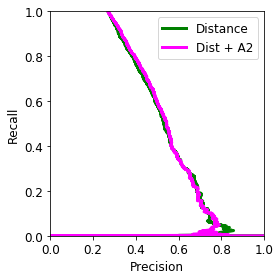

(y_thresh = 1.099)
AUC (baseline) = 0.77
AUC = 0.782


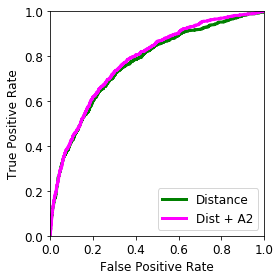

AP (baseline) = 0.417
AP = 0.417
APR (baseline) = 2.746
APR = 2.751


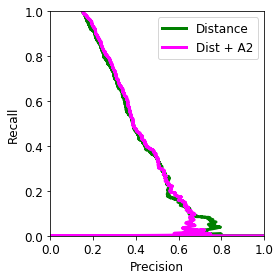

In [9]:
#Fit regression model (first pas only)

def lor_model_predict(s, m, l, w_pas, w_len, w_bias) :
    
    score = w_pas * s[:, 0] + w_len * l[:, 1] + w_bias
    
    return score

def lor_model_mse(w_bundle, s, m, l, y_true) :
    
    w_pas = w_bundle[0]
    w_len = w_bundle[1]
    w_bias = w_bundle[2]
    
    y_pred = lor_model_predict(s, m, l, w_pas, w_len, w_bias)
    
    mse = (y_pred - y_true)**2
    
    return np.mean(mse)

y_true = lor_prox

w0 = np.zeros(3)

res = minimize(lor_model_mse, w0, args=(s, m, l, y_true), method='BFGS', options={'disp': True})

w_pas = res.x[0]
w_len = res.x[1]
w_bias = res.x[2]

print(res.x)

y_pred = lor_model_predict(s, m, l, w_pas, w_len, w_bias)

#Baseline
w0 = np.zeros(3)

res = minimize(lor_model_mse, w0, args=(np.zeros(s.shape), m, l, y_true), method='BFGS', options={'disp': True})

w_pas_bl = res.x[0]
w_len_bl = res.x[1]
w_bias_bl = res.x[2]

print(res.x)

y_pred_bl = lor_model_predict(s, m, l, w_pas_bl, w_len_bl, w_bias_bl)

spearman_r_val, _ = spearmanr(y_pred, y_true)
spearman_r_val_bl, _ = spearmanr(y_pred_bl, y_true)

print("- Spearman r = " + str(round(spearman_r_val, 3)))
print("- Spearman r (baseline) = " + str(round(spearman_r_val_bl, 3)))
print("- n = " + str(y_true.shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_pred, y_true, c='black', s=15, alpha=0.1)

#plt.xlim(-3., 3.)
#plt.ylim(-3., 3.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted LOR", fontsize=12)
plt.ylabel("Measured LOR", fontsize=12)

plt.title("Pred. vs. Meas. LOR", fontsize=12)

plt.tight_layout()

plt.show()


low_qtl = np.quantile(y_pred, q=0.1)
high_qtl = np.quantile(y_pred, q=0.9)

f = plt.figure(figsize=(4, 4))

plt.scatter(y_1_prox, y_2_prox, cmap='bwr', c=y_pred, vmin=low_qtl, vmax=high_qtl, s=15, alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI", fontsize=12)

plt.tight_layout()

plt.show()


y_thresh = np.log(2.)

print("(y_thresh = " + str(round(y_thresh, 3)) + ")")

fpr, tpr, _ = roc_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred)
auc = roc_auc_score(np.array(y_true > y_thresh, dtype=np.float), y_pred)

fpr_bl, tpr_bl, _ = roc_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)
auc_bl = roc_auc_score(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)

print("AUC (baseline) = " + str(round(auc_bl, 3)))
print("AUC = " + str(round(auc, 3)))

f = plt.figure(figsize=(4, 4))

l1 = plt.plot(fpr_bl, tpr_bl, color='green', linewidth=3, label='Distance')
l2 = plt.plot(fpr, tpr, color='magenta', linewidth=3, label='Dist + A2')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plt.legend(handles=[l1[0], l2[0]], fontsize=12)

plt.tight_layout()

plt.show()


prec, rec, _ = precision_recall_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred)
ap = average_precision_score(np.array(y_true > y_thresh, dtype=np.float), y_pred)

prec_bl, rec_bl, _ = precision_recall_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)
ap_bl = average_precision_score(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)

print("AP (baseline) = " + str(round(ap_bl, 3)))
print("AP = " + str(round(ap, 3)))

print("APR (baseline) = " + str(round(ap_bl / (np.sum(y_true > y_thresh) / y_true.shape[0]), 3)))
print("APR = " + str(round(ap / (np.sum(y_true > y_thresh) / y_true.shape[0]), 3)))

f = plt.figure(figsize=(4, 4))

l1 = plt.plot(prec_bl, rec_bl, color='green', linewidth=3, label='Distance')
l2 = plt.plot(prec, rec, color='magenta', linewidth=3, label='Dist + A2')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Precision", fontsize=12)
plt.ylabel("Recall", fontsize=12)

plt.legend(handles=[l1[0], l2[0]], fontsize=12)

plt.tight_layout()

plt.show()


y_thresh = np.log(3.)

print("(y_thresh = " + str(round(y_thresh, 3)) + ")")

fpr, tpr, _ = roc_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred)
auc = roc_auc_score(np.array(y_true > y_thresh, dtype=np.float), y_pred)

fpr_bl, tpr_bl, _ = roc_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)
auc_bl = roc_auc_score(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)

print("AUC (baseline) = " + str(round(auc_bl, 3)))
print("AUC = " + str(round(auc, 3)))

f = plt.figure(figsize=(4, 4))

l1 = plt.plot(fpr_bl, tpr_bl, color='green', linewidth=3, label='Distance')
l2 = plt.plot(fpr, tpr, color='magenta', linewidth=3, label='Dist + A2')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plt.legend(handles=[l1[0], l2[0]], fontsize=12)

plt.tight_layout()

plt.show()


prec, rec, _ = precision_recall_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred)
ap = average_precision_score(np.array(y_true > y_thresh, dtype=np.float), y_pred)

prec_bl, rec_bl, _ = precision_recall_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)
ap_bl = average_precision_score(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)

print("AP (baseline) = " + str(round(ap_bl, 3)))
print("AP = " + str(round(ap, 3)))

print("APR (baseline) = " + str(round(ap_bl / (np.sum(y_true > y_thresh) / y_true.shape[0]), 3)))
print("APR = " + str(round(ap / (np.sum(y_true > y_thresh) / y_true.shape[0]), 3)))

f = plt.figure(figsize=(4, 4))

l1 = plt.plot(prec_bl, rec_bl, color='green', linewidth=3, label='Distance')
l2 = plt.plot(prec, rec, color='magenta', linewidth=3, label='Dist + A2')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Precision", fontsize=12)
plt.ylabel("Recall", fontsize=12)

plt.legend(handles=[l1[0], l2[0]], fontsize=12)

plt.tight_layout()

plt.show()


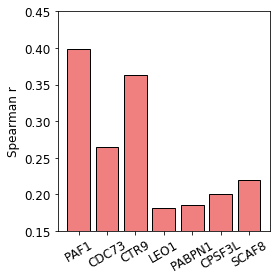

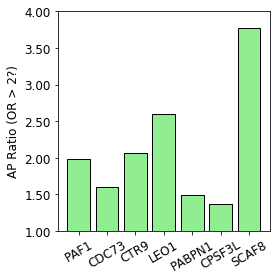

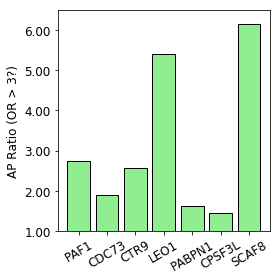

In [15]:
#Summarize predictive performance for different perturbations

import matplotlib

perturb_genes = ['PAF1', 'CDC73', 'CTR9', 'LEO1', 'PABPN1', 'CPSF3L', 'SCAF8']

rs = [0.399, 0.265, 0.363, 0.182, 0.185, 0.200, 0.220]
aprs_2 = [1.988, 1.599, 2.059, 2.602, 1.491, 1.366, 3.779]
aprs_3 = [2.751, 1.893, 2.573, 5.400, 1.609, 1.443, 6.146]

f = plt.figure(figsize=(4, 4))

plt.bar(np.arange(len(perturb_genes)), rs, color='lightcoral', edgecolor='black', linewidth=1)

plt.xticks(np.arange(len(perturb_genes)), perturb_genes, fontsize=12, rotation=30)
plt.yticks(fontsize=12)

plt.ylabel("Spearman r", fontsize=12)

plt.ylim(0.15, 0.45)

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(4, 4))

plt.bar(np.arange(len(perturb_genes)), aprs_2, color='lightgreen', edgecolor='black', linewidth=1)

plt.xticks(np.arange(len(perturb_genes)), perturb_genes, fontsize=12, rotation=30)
plt.yticks(fontsize=12)

plt.ylabel("AP Ratio (OR > 2?)", fontsize=12)

plt.ylim(1.0, 4.0)

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))

plt.tight_layout()

plt.show()

f = plt.figure(figsize=(4, 4))

plt.bar(np.arange(len(perturb_genes)), aprs_3, color='lightgreen', edgecolor='black', linewidth=1)

plt.xticks(np.arange(len(perturb_genes)), perturb_genes, fontsize=12, rotation=30)
plt.yticks(fontsize=12)

plt.ylabel("AP Ratio (OR > 3?)", fontsize=12)

plt.ylim(1.0, 6.5)

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))

plt.tight_layout()

plt.show()


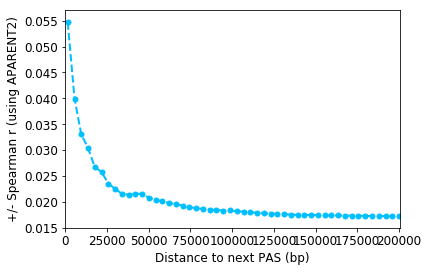

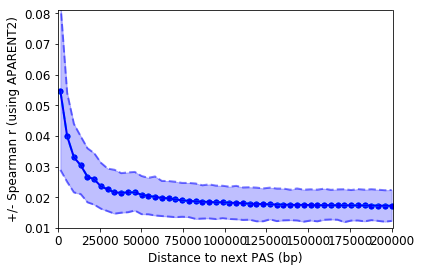

In [14]:
#Analyze improvement of using APARENT2 score

#By site distance

l_cutoffs = np.linspace(1500, 2e5, 50)

f = plt.figure(figsize=(6, 4))

r_vals = []
for l_cutoff in l_cutoffs.tolist() :
    keep_index = np.exp(l[:, 1])-1. <= l_cutoff

    r_vals.append(spearmanr(y_pred[keep_index], y_true[keep_index])[0] - spearmanr(y_pred_bl[keep_index], y_true[keep_index])[0])

r_vals = np.array(r_vals)

plt.plot(l_cutoffs, r_vals, color='deepskyblue', linewidth=2, linestyle='--')
plt.scatter(l_cutoffs, r_vals, s=25, color='deepskyblue')

plt.xlim(0-100, 200000+500)
plt.ylim(0.015, 0.057)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Distance to next PAS (bp)", fontsize=12)
plt.ylabel("+/- Spearman r (using APARENT2)", fontsize=12)

plt.show()

#Re-run analysis with 1,000-fold bootstrapping
n_bootstrap = 1000

l_cutoffs = np.linspace(1500, 2e5, 50)

f = plt.figure(figsize=(6, 4))

r_vals = []
r_vals_lower = []
r_vals_upper = []
for l_cutoff in l_cutoffs.tolist() :
    keep_index = np.exp(l[:, 1])-1. <= l_cutoff

    r_vals.append(spearmanr(y_pred[keep_index], y_true[keep_index])[0] - spearmanr(y_pred_bl[keep_index], y_true[keep_index])[0])

    r_vals_bootstrap = []
    for bootstrap_ix in range(n_bootstrap) :
        sel_index = np.nonzero(keep_index)[0].tolist()
        sel_index = np.random.choice(sel_index, size=(len(sel_index),), replace=True)

        r_vals_bootstrap.append(spearmanr(y_pred[sel_index], y_true[sel_index])[0] - spearmanr(y_pred_bl[sel_index], y_true[sel_index])[0])

    r_vals_lower.append(np.quantile(r_vals_bootstrap, q=0.05))
    r_vals_upper.append(np.quantile(r_vals_bootstrap, q=0.95))

r_vals = np.array(r_vals)
r_vals_lower = np.array(r_vals_lower)
r_vals_upper = np.array(r_vals_upper)

plt.plot(l_cutoffs, r_vals, color='deepskyblue', linewidth=2, linestyle='--')
plt.scatter(l_cutoffs, r_vals, s=25, color='deepskyblue')

plt.plot(l_cutoffs, r_vals_lower, color='blue', alpha=0.5, linewidth=2, linestyle='--')
plt.plot(l_cutoffs, r_vals, color='blue', linewidth=2, linestyle='-')
plt.plot(l_cutoffs, r_vals_upper, color='blue', alpha=0.5, linewidth=2, linestyle='--')
plt.fill_between(l_cutoffs, r_vals_lower, r_vals_upper, color='blue', alpha=0.25)
plt.scatter(l_cutoffs, r_vals, s=25, color='blue')

plt.xlim(0-100, 200000+500)
plt.ylim(0.01, 0.081)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Distance to next PAS (bp)", fontsize=12)
plt.ylabel("+/- Spearman r (using APARENT2)", fontsize=12)

plt.show()


Optimization terminated successfully.
         Current function value: 0.541751
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 10
[ 0.04988193  0.16377832  0.02963723 -1.17277701]
Optimization terminated successfully.
         Current function value: 0.548048
         Iterations: 4
         Function evaluations: 54
         Gradient evaluations: 9
[ 0.          0.17648804  0.03119635 -1.35448619]
- Spearman r = 0.429
- Spearman r (baseline) = 0.418
- n = 6644


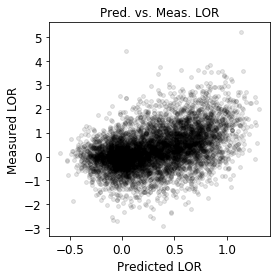

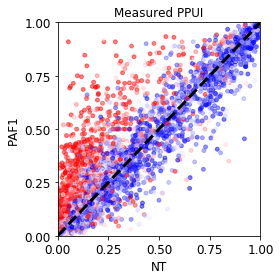

(y_thresh = 1.099)
AUC (baseline) = 0.789
AUC = 0.798


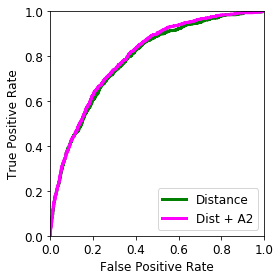

AP (baseline) = 0.413
AP = 0.417
APR (baseline) = 2.721
APR = 2.75


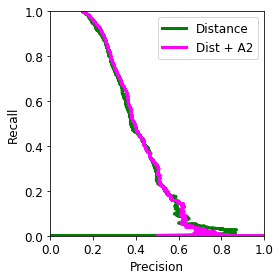

In [11]:
#Fit regression model (first pas only, distance to third PAS included)

def lor_model_predict(s, m, l, w_pas, w_len, w_bias) :
    
    score = w_pas * s[:, 0] + w_len[0] * l[:, 1] + w_len[1] * l[:, 2] + w_bias
    
    return score

def lor_model_mse(w_bundle, s, m, l, y_true) :
    
    w_pas = w_bundle[0]
    w_len = w_bundle[1:3]
    w_bias = w_bundle[3]
    
    y_pred = lor_model_predict(s, m, l, w_pas, w_len, w_bias)
    
    mse = (y_pred - y_true)**2
    
    return np.mean(mse)

y_true = lor_prox

w0 = np.zeros(4)

res = minimize(lor_model_mse, w0, args=(s, m, l, y_true), method='BFGS', options={'disp': True})

w_pas = res.x[0]
w_len = res.x[1:3]
w_bias = res.x[3]

print(res.x)

y_pred = lor_model_predict(s, m, l, w_pas, w_len, w_bias)

#Baseline
w0 = np.zeros(4)

res = minimize(lor_model_mse, w0, args=(np.zeros(s.shape), m, l, y_true), method='BFGS', options={'disp': True})

w_pas_bl = res.x[0]
w_len_bl = res.x[1:3]
w_bias_bl = res.x[3]

print(res.x)

y_pred_bl = lor_model_predict(s, m, l, w_pas_bl, w_len_bl, w_bias_bl)

spearman_r_val, _ = spearmanr(y_pred, y_true)
spearman_r_val_bl, _ = spearmanr(y_pred_bl, y_true)

print("- Spearman r = " + str(round(spearman_r_val, 3)))
print("- Spearman r (baseline) = " + str(round(spearman_r_val_bl, 3)))
print("- n = " + str(y_true.shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_pred, y_true, c='black', s=15, alpha=0.1)

#plt.xlim(-3., 3.)
#plt.ylim(-3., 3.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted LOR", fontsize=12)
plt.ylabel("Measured LOR", fontsize=12)

plt.title("Pred. vs. Meas. LOR", fontsize=12)

plt.tight_layout()

plt.show()


low_qtl = np.quantile(y_pred, q=0.1)
high_qtl = np.quantile(y_pred, q=0.9)

f = plt.figure(figsize=(4, 4))

plt.scatter(y_1_prox, y_2_prox, cmap='bwr', c=y_pred, vmin=low_qtl, vmax=high_qtl, s=15, alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI", fontsize=12)

plt.tight_layout()

plt.show()


y_thresh = np.log(3.)

print("(y_thresh = " + str(round(y_thresh, 3)) + ")")

fpr, tpr, _ = roc_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred)
auc = roc_auc_score(np.array(y_true > y_thresh, dtype=np.float), y_pred)

fpr_bl, tpr_bl, _ = roc_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)
auc_bl = roc_auc_score(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)

print("AUC (baseline) = " + str(round(auc_bl, 3)))
print("AUC = " + str(round(auc, 3)))

f = plt.figure(figsize=(4, 4))

l1 = plt.plot(fpr_bl, tpr_bl, color='green', linewidth=3, label='Distance')
l2 = plt.plot(fpr, tpr, color='magenta', linewidth=3, label='Dist + A2')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plt.legend(handles=[l1[0], l2[0]], fontsize=12)

plt.tight_layout()

plt.show()


prec, rec, _ = precision_recall_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred)
ap = average_precision_score(np.array(y_true > y_thresh, dtype=np.float), y_pred)

prec_bl, rec_bl, _ = precision_recall_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)
ap_bl = average_precision_score(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)

print("AP (baseline) = " + str(round(ap_bl, 3)))
print("AP = " + str(round(ap, 3)))

print("APR (baseline) = " + str(round(ap_bl / (np.sum(y_true > y_thresh) / y_true.shape[0]), 3)))
print("APR = " + str(round(ap / (np.sum(y_true > y_thresh) / y_true.shape[0]), 3)))

f = plt.figure(figsize=(4, 4))

l1 = plt.plot(prec_bl, rec_bl, color='green', linewidth=3, label='Distance')
l2 = plt.plot(prec, rec, color='magenta', linewidth=3, label='Dist + A2')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Precision", fontsize=12)
plt.ylabel("Recall", fontsize=12)

plt.legend(handles=[l1[0], l2[0]], fontsize=12)

plt.tight_layout()

plt.show()


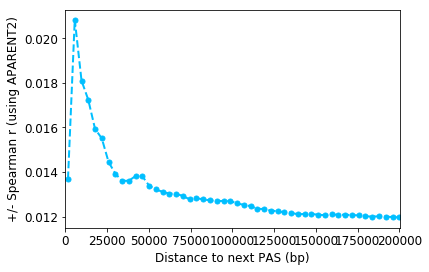

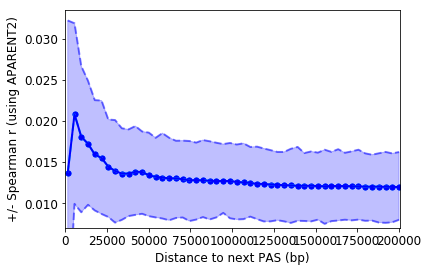

In [16]:
#Analyze improvement of using APARENT2 score

#By site distance

l_cutoffs = np.linspace(1500, 2e5, 50)

f = plt.figure(figsize=(6, 4))

r_vals = []
for l_cutoff in l_cutoffs.tolist() :
    keep_index = np.exp(l[:, 1])-1. <= l_cutoff

    r_vals.append(spearmanr(y_pred[keep_index], y_true[keep_index])[0] - spearmanr(y_pred_bl[keep_index], y_true[keep_index])[0])

r_vals = np.array(r_vals)

plt.plot(l_cutoffs, r_vals, color='deepskyblue', linewidth=2, linestyle='--')
plt.scatter(l_cutoffs, r_vals, s=25, color='deepskyblue')

plt.xlim(0-100, 200000+500)
plt.ylim(0.0115, 0.02125)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Distance to next PAS (bp)", fontsize=12)
plt.ylabel("+/- Spearman r (using APARENT2)", fontsize=12)

plt.show()

#Re-run analysis with 1,000-fold bootstrapping
n_bootstrap = 1000

l_cutoffs = np.linspace(1500, 2e5, 50)

f = plt.figure(figsize=(6, 4))

r_vals = []
r_vals_lower = []
r_vals_upper = []
for l_cutoff in l_cutoffs.tolist() :
    keep_index = np.exp(l[:, 1])-1. <= l_cutoff

    r_vals.append(spearmanr(y_pred[keep_index], y_true[keep_index])[0] - spearmanr(y_pred_bl[keep_index], y_true[keep_index])[0])

    r_vals_bootstrap = []
    for bootstrap_ix in range(n_bootstrap) :
        sel_index = np.nonzero(keep_index)[0].tolist()
        sel_index = np.random.choice(sel_index, size=(len(sel_index),), replace=True)

        r_vals_bootstrap.append(spearmanr(y_pred[sel_index], y_true[sel_index])[0] - spearmanr(y_pred_bl[sel_index], y_true[sel_index])[0])

    r_vals_lower.append(np.quantile(r_vals_bootstrap, q=0.05))
    r_vals_upper.append(np.quantile(r_vals_bootstrap, q=0.95))

r_vals = np.array(r_vals)
r_vals_lower = np.array(r_vals_lower)
r_vals_upper = np.array(r_vals_upper)

plt.plot(l_cutoffs, r_vals, color='deepskyblue', linewidth=2, linestyle='--')
plt.scatter(l_cutoffs, r_vals, s=25, color='deepskyblue')

plt.plot(l_cutoffs, r_vals_lower, color='blue', alpha=0.5, linewidth=2, linestyle='--')
plt.plot(l_cutoffs, r_vals, color='blue', linewidth=2, linestyle='-')
plt.plot(l_cutoffs, r_vals_upper, color='blue', alpha=0.5, linewidth=2, linestyle='--')
plt.fill_between(l_cutoffs, r_vals_lower, r_vals_upper, color='blue', alpha=0.25)
plt.scatter(l_cutoffs, r_vals, s=25, color='blue')

plt.xlim(0-100, 200000+500)
plt.ylim(0.007, 0.0335)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Distance to next PAS (bp)", fontsize=12)
plt.ylabel("+/- Spearman r (using APARENT2)", fontsize=12)

plt.show()


Optimization terminated successfully.
         Current function value: 0.525774
         Iterations: 144
         Function evaluations: 3576
         Gradient evaluations: 149
[ 4.23008310e-02 -4.11905724e-01 -1.41608584e-01 -1.04383077e-01
 -5.63380948e-02  1.11481478e+00 -7.87003956e-01  2.19369783e-02
  2.54488415e-02 -7.76555049e-03  2.11164488e-01  3.43447983e-01
  3.30805371e-01  2.86513860e-01  2.61071392e-01  2.50869974e-01
  2.03818295e-01 -1.25344601e-01  4.13234700e-01 -4.58548580e-02
 -1.52443276e+00  6.40710352e-07]
Optimization terminated successfully.
         Current function value: 0.531712
         Iterations: 52
         Function evaluations: 1320
         Gradient evaluations: 55
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.26605687e-01  3.43972507e-01
  3.04407269e-01  2.41842808e-01  2.24180975e-01  2.76709738e-01
 -1.28651062e-01 -1.48112836e-0

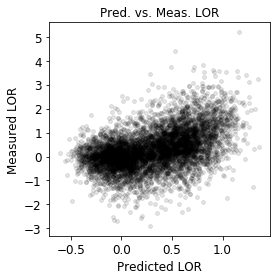

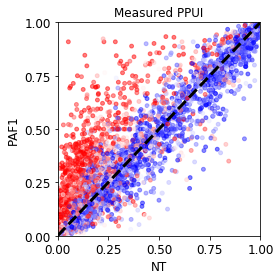

(y_thresh = 1.099)
AUC (baseline) = 0.817
AUC = 0.823


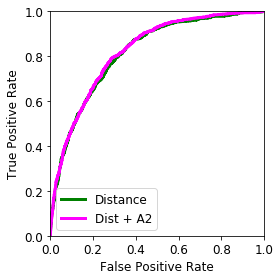

AP (baseline) = 0.452
AP = 0.456
APR (baseline) = 2.98
APR = 3.005


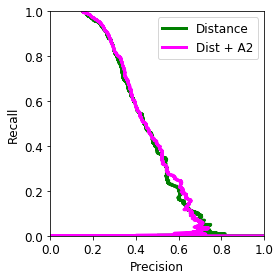

In [12]:
#Fit regression model (generalized PAS model, attention)

def lor_model_predict(s, m, l, l_cumulative, w_pas, w_len, w_bias) :
    
    score = w_pas[0] * s[:, 0] + w_bias[0]
    
    exp = np.exp(w_len[1:] * l_cumulative[:, 1:] + w_pas[1:] * s[:, 1:] + w_bias[1]) * m[:, 1:]
    p = exp / np.sum(exp, axis=-1)[:, None]
    pl = p * l_cumulative[:, 1:]
    
    score += w_len[0] * np.sum(pl, axis=-1)
    
    return score

def lor_model_mse(w_bundle, s, m, l, l_cumulative, y_true) :
    
    w_pas = w_bundle[0:10]
    w_len = w_bundle[10:20]
    w_bias = w_bundle[20:22]
    
    y_pred = lor_model_predict(s, m, l, l_cumulative, w_pas, w_len, w_bias)
    
    mse = (y_pred - y_true)**2 + 1e-4 * np.sum(w_pas**2) + 1e-4 * np.sum(w_len**2)
    
    return np.mean(mse)

y_true = lor_prox

w0 = np.zeros(22)

res = minimize(lor_model_mse, w0, args=(s, m, l, l_cumulative, y_true), method='BFGS', options={'disp': True})

w_pas = res.x[0:10]
w_len = res.x[10:20]
w_bias = res.x[20:22]

print(res.x)

y_pred = lor_model_predict(s, m, l, l_cumulative, w_pas, w_len, w_bias)

#Baseline
w0 = np.zeros(22)

res = minimize(lor_model_mse, w0, args=(np.zeros(s.shape), m, l, l_cumulative, y_true), method='BFGS', options={'disp': True})

w_pas_bl = res.x[0:10]
w_len_bl = res.x[10:20]
w_bias_bl = res.x[20:22]

print(res.x)

y_pred_bl = lor_model_predict(s, m, l, l_cumulative, w_pas_bl, w_len_bl, w_bias_bl)

spearman_r_val, _ = spearmanr(y_pred, y_true)
spearman_r_val_bl, _ = spearmanr(y_pred_bl, y_true)

print("- Spearman r = " + str(round(spearman_r_val, 3)))
print("- Spearman r (baseline) = " + str(round(spearman_r_val_bl, 3)))
print("- n = " + str(y_true.shape[0]))

f = plt.figure(figsize=(4, 4))

plt.scatter(y_pred, y_true, c='black', s=15, alpha=0.1)

#plt.xlim(-3., 3.)
#plt.ylim(-3., 3.)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Predicted LOR", fontsize=12)
plt.ylabel("Measured LOR", fontsize=12)

plt.title("Pred. vs. Meas. LOR", fontsize=12)

plt.tight_layout()

plt.show()

low_qtl = np.quantile(y_pred, q=0.1)
high_qtl = np.quantile(y_pred, q=0.9)

f = plt.figure(figsize=(4, 4))

plt.scatter(y_1_prox, y_2_prox, cmap='bwr', c=y_pred, vmin=low_qtl, vmax=high_qtl, s=15, alpha=0.5)

plt.plot([0, 1], [0, 1], color='black', linewidth=3, linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12)

plt.xlabel(cell_type_1, fontsize=12)
plt.ylabel(cell_type_2, fontsize=12)

plt.title("Measured PPUI", fontsize=12)

plt.tight_layout()

plt.show()


y_thresh = np.log(3.)

print("(y_thresh = " + str(round(y_thresh, 3)) + ")")

fpr, tpr, _ = roc_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred)
auc = roc_auc_score(np.array(y_true > y_thresh, dtype=np.float), y_pred)

fpr_bl, tpr_bl, _ = roc_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)
auc_bl = roc_auc_score(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)

print("AUC (baseline) = " + str(round(auc_bl, 3)))
print("AUC = " + str(round(auc, 3)))

f = plt.figure(figsize=(4, 4))

l1 = plt.plot(fpr_bl, tpr_bl, color='green', linewidth=3, label='Distance')
l2 = plt.plot(fpr, tpr, color='magenta', linewidth=3, label='Dist + A2')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)

plt.legend(handles=[l1[0], l2[0]], fontsize=12)

plt.tight_layout()

plt.show()


prec, rec, _ = precision_recall_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred)
ap = average_precision_score(np.array(y_true > y_thresh, dtype=np.float), y_pred)

prec_bl, rec_bl, _ = precision_recall_curve(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)
ap_bl = average_precision_score(np.array(y_true > y_thresh, dtype=np.float), y_pred_bl)

print("AP (baseline) = " + str(round(ap_bl, 3)))
print("AP = " + str(round(ap, 3)))

print("APR (baseline) = " + str(round(ap_bl / (np.sum(y_true > y_thresh) / y_true.shape[0]), 3)))
print("APR = " + str(round(ap / (np.sum(y_true > y_thresh) / y_true.shape[0]), 3)))

f = plt.figure(figsize=(4, 4))

l1 = plt.plot(prec_bl, rec_bl, color='green', linewidth=3, label='Distance')
l2 = plt.plot(prec, rec, color='magenta', linewidth=3, label='Dist + A2')

plt.xlim(0., 1.)
plt.ylim(0., 1.)

plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Precision", fontsize=12)
plt.ylabel("Recall", fontsize=12)

plt.legend(handles=[l1[0], l2[0]], fontsize=12)

plt.tight_layout()

plt.show()


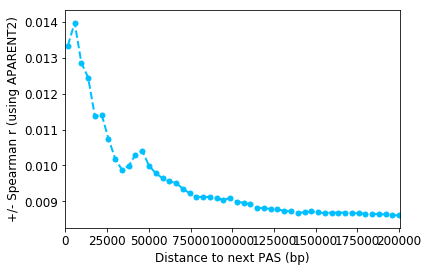

In [8]:
#Analyze improvement of using APARENT2 score

#By site distance

l_cutoffs = np.linspace(1500, 2e5, 50)

f = plt.figure(figsize=(6, 4))

r_vals = []
for l_cutoff in l_cutoffs.tolist() :
    keep_index = np.exp(l[:, 1])-1. <= l_cutoff

    r_vals.append(spearmanr(y_pred[keep_index], y_true[keep_index])[0] - spearmanr(y_pred_bl[keep_index], y_true[keep_index])[0])

r_vals = np.array(r_vals)

plt.plot(l_cutoffs, r_vals, color='deepskyblue', linewidth=2, linestyle='--')
plt.scatter(l_cutoffs, r_vals, s=25, color='deepskyblue')

plt.xlim(0-100, 200000+500)
#plt.ylim(0.0085, 0.01025)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Distance to next PAS (bp)", fontsize=12)
plt.ylabel("+/- Spearman r (using APARENT2)", fontsize=12)

plt.show()
